# ABIDE Subtype analysis
Lazy man result overview

In [1]:
# Imports
import os
import glob
import time
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Variables
mtp_list = ['rmap_part', 'dual_regression', 'stability_maps']
pheno_list = [
              '/data1/abide/Pheno/combined_406.csv',
              '/data1/abide/Pheno/site_balanced_279.csv',
              '/data1/abide/Pheno/site_and_age_balanced_194.csv'
              ]
sample_names = [
                'combined_406_sample',
                'site_279_sample',
                'site_age_194_sample'
                ]
scale_list = np.array([7, 12, 20, 36, 64])
cov_list = ['VIQ', 'DX_GROUP', 'ADOS_SOCOM_SEV','EYE_STATUS_AT_SCAN']
# Select
mtp_id = 0
sc_id = 1
phen_id = 1
cov_id = 2
# Make variables
scale = scale_list[sc_id]
mtp = mtp_list[mtp_id]
name = sample_names[phen_id]
pheno_path = pheno_list[phen_id]
cov = cov_list[cov_id]
# Fixed values
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
in_path = '/data1/subtypes/serial_preps/'

netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [6]:
# add coded variable for ratio of VIQ and PIQ
pheno['VerbRatio'] = pheno['VIQ'] / pheno['PIQ']

In [7]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [8]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

# Define some functions and the niak colormap

In [9]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

## Build the subtypes and compute the weights

In [10]:
# Load the serialized netstack
netstack = np.load(netstack_path)
corr_mat = np.load(corrmat_path)

In [11]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [12]:
netraw = np.load(netraw_path)

In [13]:
subtypes = 5

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

In [14]:
def show_simple(net_id, sbt_id, gdavg_img, sbt_store, view_mode='x', threshold=0.1, 
                view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):

    sbt = sbt_store[net_id, sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    nlp.plot_stat_map(sbt_img, display_mode='x', threshold=threshold, 
                      cut_coords=view_range, black_bg=True,
                     axes=ax)
    return fig

## Run the GLM
Prepare the model matrix, constrain the sample and then run

In [15]:
# Get the subjects that have the covariate
cov_index = pd.notnull(pheno[cov])
cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
if cov == 'DX_GROUP':
    other_factors[cov] = other_factors[cov].values - 1
else:
    # Demean the covariate
    other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)

# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)
# Get the weights for these subjects
cov_weight = weight_store[..., cov_index.values]

# Prepare storage variables
res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = smi.multipletests(pval_vec.flatten(), alpha=0.05, method='fdr_bh')
pcorr = np.reshape(pcorr_vec[1], pval_store.shape)
pthresh = np.reshape(pcorr_vec[0], pval_store.shape)

## Auto display the results

In [35]:
print(res_store[11][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3.856
Date:                Wed, 23 Dec 2015   Prob (F-statistic):           0.000328
Time:                        12:10:52   Log-Likelihood:                 73.283
No. Observations:                 187   AIC:                            -128.6
Df Residuals:                     178   BIC:                            -99.49
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
INTERCEPT          0.1066      0.073      1.

In [34]:
pval_store[11,1]

0.0012977375424475118

In [33]:
pthresh[11,1]

True

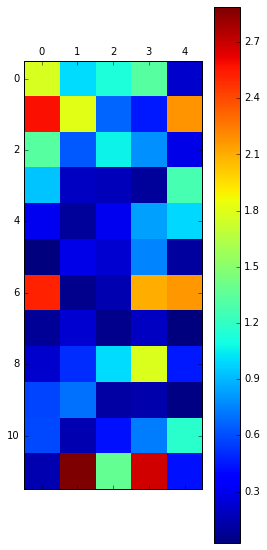

In [30]:
plt.matshow(-np.log10(pval_store))
plt.colorbar()

In [16]:
# Do a bonferroni correction too
bonfcrit = 0.05 / np.prod(pval_store.shape)
bonfvec = pval_vec < bonfcrit
bonfthresh = np.reshape(bonfvec, pval_store.shape)

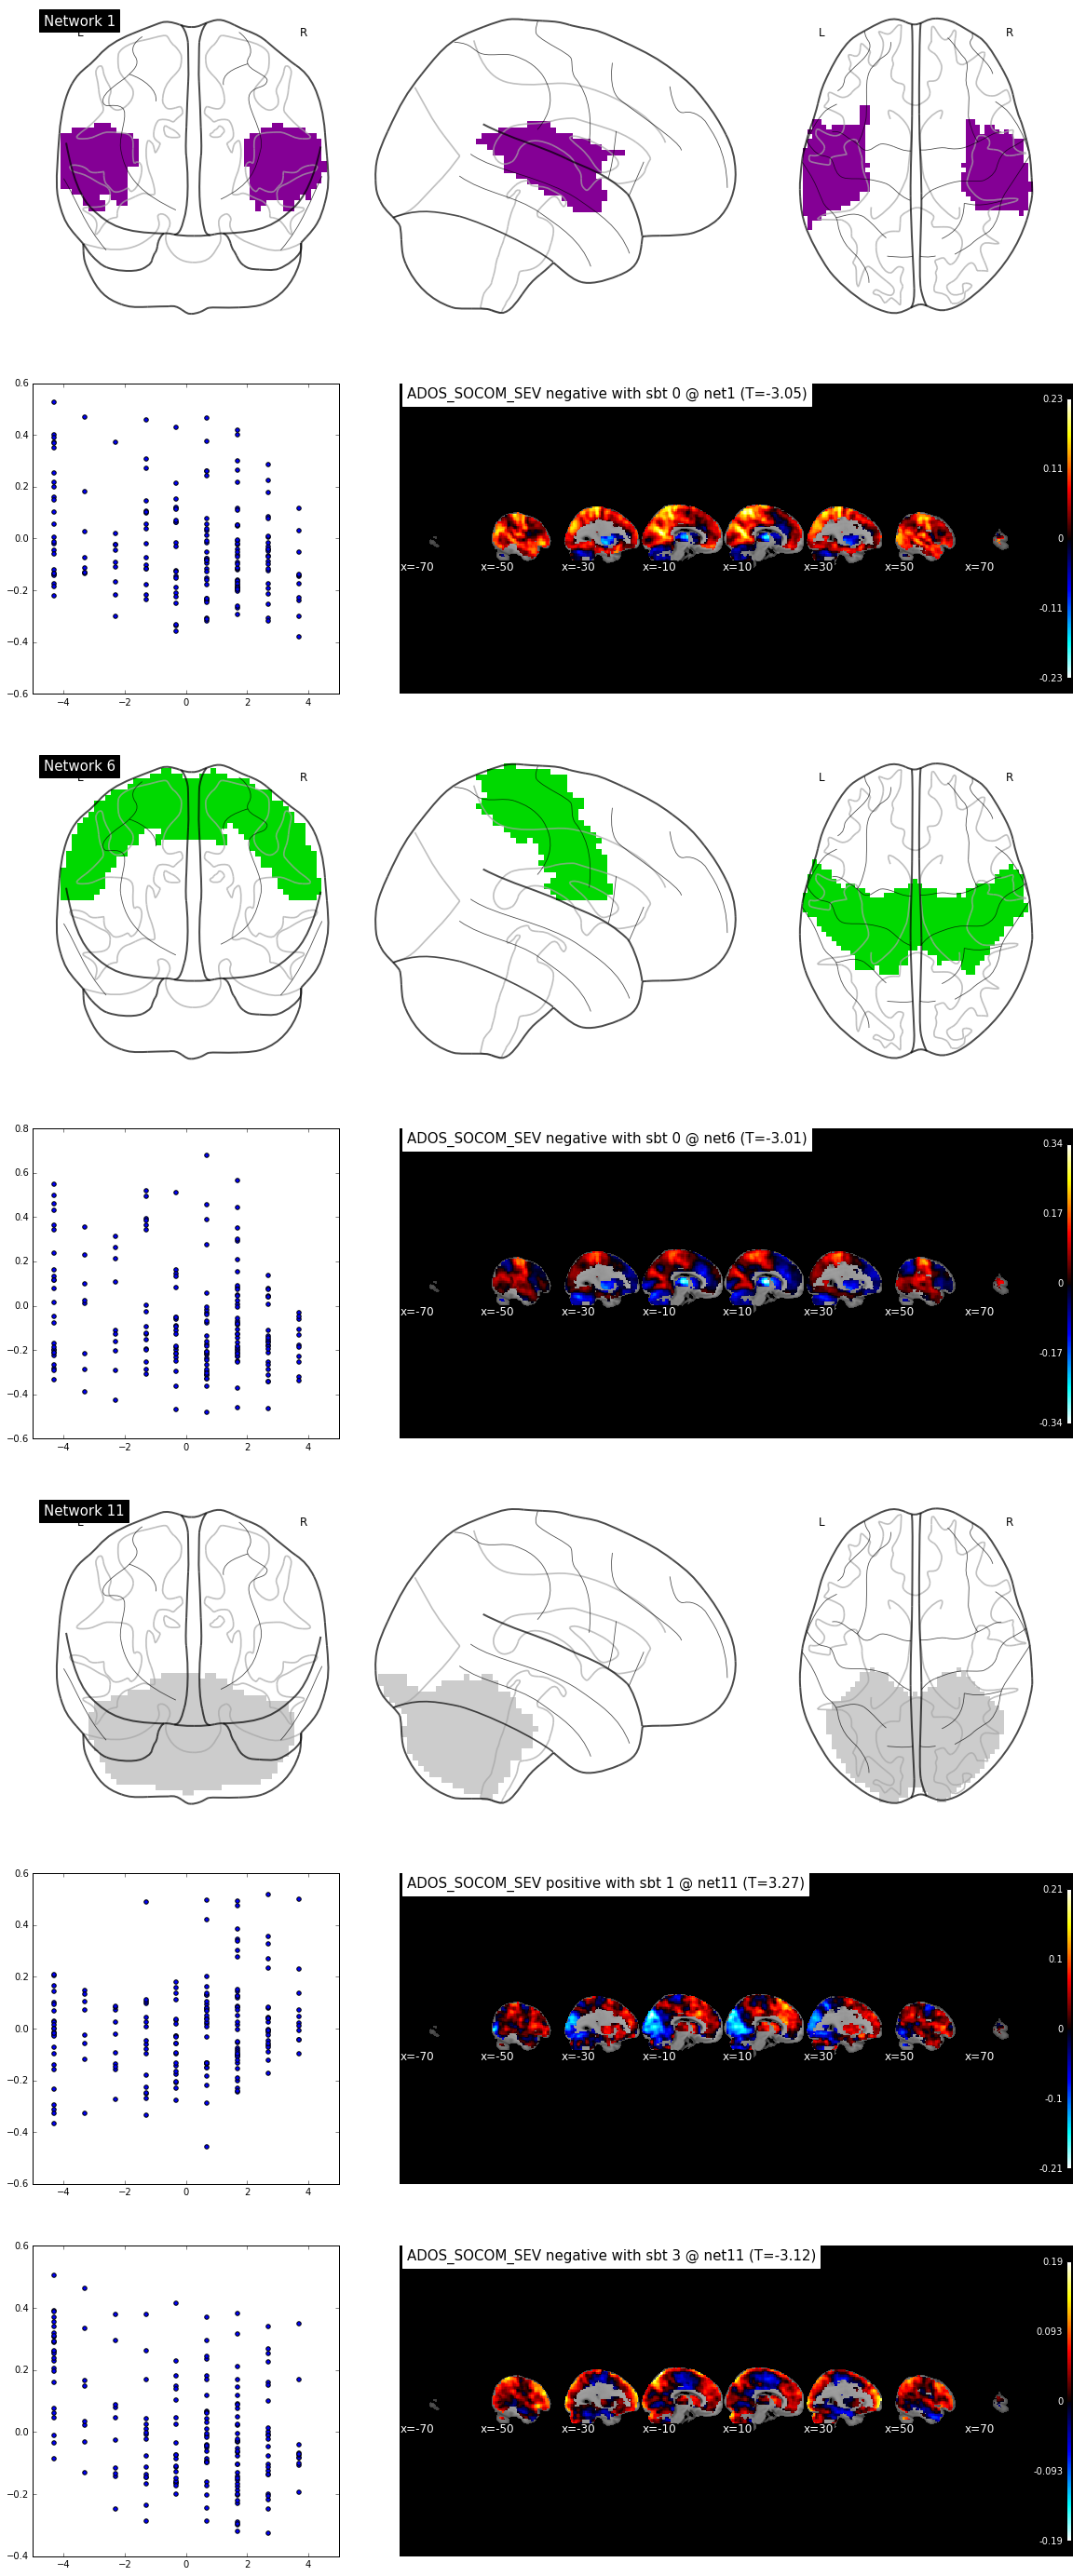

In [48]:
# Find hits
do_print = False
# Get the two lists of hit indices
net_hits, sbt_hits = np.where(pthresh)
cov_val = glm_pheno[cov].values
# Check if there is anything
if net_hits.size:
    # Find the unique networks that have a hit
    nets = np.unique(net_hits)
    # Get the number of hits
    n_hits = np.sum(net_hits!=0)
    n_figs = n_hits+len(nets)
    # Prepare the figure
    fig = plt.figure(figsize=(20,7*n_figs))
    gs = gridspec.GridSpec(n_figs, 3)
    counter = -1
    # Loop through the unique networks to have
    # an external loop
    for net in nets:
        # Announce the current network
        if do_print:
            print('Now showing results for network {}'.format(net))
        # Display the current network
        if not do_print:
            counter += 1
            ax1 = fig.add_subplot(gs[counter, :])
            nlp.plot_glass_brain(nil.image.index_img(prior_img, net), cmap=plt.cm.spectral, 
                                 colorbar=False, vmin=1, vmax=scale,axes=ax1,
                                title='Network {}'.format(net))
        # Find the subtypes that belong to this network
        sbts = sbt_hits[net_hits==net]
        # Go through these hits on the subtype level
        for sbt in sbts:
            counter += 1
            ax2a = fig.add_subplot(gs[counter, 0])
            # Get the sbt weights
            sbt_w = cov_weight[net, sbt, :]
            # Plot these over the covariate
            ax2a.scatter(cov_val, sbt_w)
            ax2b = fig.add_subplot(gs[counter, 1:])
            # Get the corresponding GLM result
            res = res_store[net][sbt]
            # Get sbt t-value
            sbt_t = res.tvalues[cov]
            # code orientation
            if sbt_t < 0:
                orient = 'negative'
            else: 
                orient = 'positive'
            # Announce result
            if do_print:
                print('   subtype {} of network {} has a {} relationship with {}'.format(sbt, net, orient, cov))
            # Show the result
            if do_print:
                print(res.summary2())
            # Show the subtype
            sbt_map = sbt_store[net, sbt,:]
            tmp = np.zeros_like(mask, dtype=np.float)
            tmp[mask] = sbt_map
            sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
            if not do_print:
                nlp.plot_stat_map(sbt_img, display_mode='x', threshold=0, 
                              cut_coords=[-70,-50, -30, -10, 10, 30, 50, 70], black_bg=True,axes=ax2b,
                                 title='{} {} with sbt {} @ net{} (T={:.2f})'.format(cov, orient, sbt, net, sbt_t))
else:
    print('Nothing is significant')